# SDXL Naruto LoRA - Inference & Comparison

This notebook compares the base SDXL model with the fine-tuned Naruto LoRA model.

**Memory-Efficient Approach**: We generate images sequentially (base first, then LoRA) to avoid GPU OOM.

## Setup

In [1]:
# Install dependencies (run only if needed)
!pip install -q diffusers transformers accelerate safetensors xformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.9/122.9 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 88.5 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.2
    Uninstalling transformers-4.57.2:
      Successfully uninstalled transformers-4.57.2


In [2]:
import torch
import matplotlib.pyplot as plt
from diffusers import StableDiffusionXLPipeline, DPMSolverMultistepScheduler
from PIL import Image
import gc

# Check GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Available VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: Tesla T4
Available VRAM: 15.83 GB


## Load LoRA Weights

### To load our trained LoRA weights:

In [ ]:
# Load from Google Drive 

from google.colab import drive
drive.mount('/content/drive')

# Set the path to your model in Google Drive
LORA_PATH = "/content/drive/MyDrive/sdxl-naruto-lora"

# Verify the path
import os
if os.path.exists(LORA_PATH):
    print(f"✓ Found LoRA weights at: {LORA_PATH}")
    print("\nFiles in directory:")
    for file in os.listdir(LORA_PATH):
        print(f"  - {file}")
else:
    print(f"❌ Path not found: {LORA_PATH}")
    print("\nPlease check your Google Drive path!")
    print("Your model folder should contain:")
    print("  - adapter_config.json")
    print("  - adapter_model.safetensors (or .bin)")

Mounted at /content/drive
✓ Found LoRA weights at: /content/drive/MyDrive/sdxl-naruto-lora

Files in directory:
  - adapter_model.safetensors
  - README.md
  - training.log
  - adapter_config.json
  - checkpoint-200
  - checkpoint-400
  - checkpoint-800
  - checkpoint-1000
  - checkpoint-600


Device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


  0%|          | 0/30 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Injecting PEFT LoRA into UNet...
LoRA loaded.


  0%|          | 0/30 [00:00<?, ?it/s]

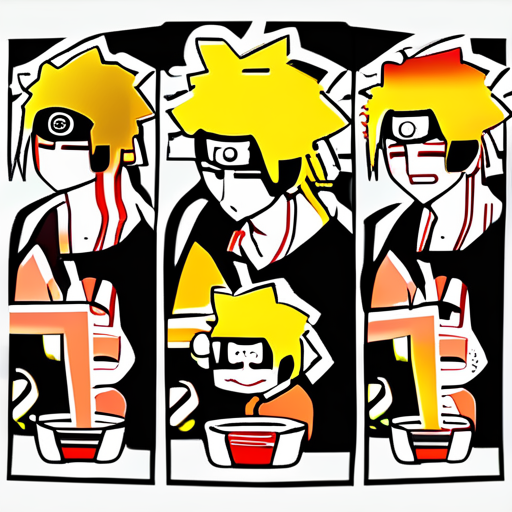

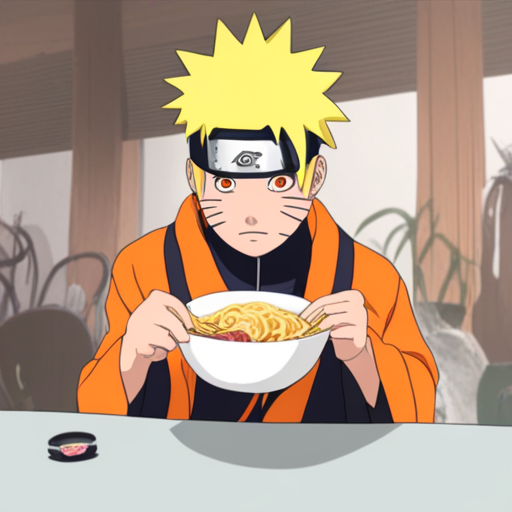

In [ ]:
import torch
from diffusers import StableDiffusionXLPipeline, DPMSolverMultistepScheduler
from peft import PeftModel          

BASE_MODEL  = "stabilityai/stable-diffusion-xl-base-1.0"
LORA_PATH   = "/content/drive/MyDrive/sdxl-naruto-lora"

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

prompt   = "Naruto Uzumaki eating ramen in anime style"
seed     = 1234
steps    = 30
guidance = 7.5
h, w     = 512, 512

# 1) Base pipeline
pipe_base = StableDiffusionXLPipeline.from_pretrained(
    BASE_MODEL,
    variant="fp16",
    torch_dtype=torch.float16,
    use_safetensors=True,
).to(device)

pipe_base.scheduler = DPMSolverMultistepScheduler.from_config(
    pipe_base.scheduler.config
)

g = torch.Generator(device=device).manual_seed(seed)
img_base = pipe_base(
    prompt=prompt,
    num_inference_steps=steps,
    guidance_scale=guidance,
    generator=g,
    height=h,
    width=w,
).images[0]

# 2) LoRA pipeline
pipe_lora = StableDiffusionXLPipeline.from_pretrained(
    BASE_MODEL,
    variant="fp16",
    torch_dtype=torch.float16,
    use_safetensors=True,
).to(device)

pipe_lora.scheduler = DPMSolverMultistepScheduler.from_config(
    pipe_lora.scheduler.config
)

print("Injecting PEFT LoRA into UNet...")
pipe_lora.unet = PeftModel.from_pretrained(
    pipe_lora.unet,   # base UNet from SDXL
    LORA_PATH,        # folder with adapter_model.safetensors + adapter_config.json
)
print("LoRA loaded.")

g = torch.Generator(device=device).manual_seed(seed)
img_lora = pipe_lora(
    prompt=prompt,
    num_inference_steps=steps,
    guidance_scale=guidance,
    generator=g,
    height=h,
    width=w,
    # cross_attention_kwargs={"scale": 1.0},  
).images[0]

display(img_base)
display(img_lora)


Device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder/model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

text_encoder_2/model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

unet/diffusion_pytorch_model.fp16.safete(…):   0%|          | 0.00/5.14G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.fp16.safeten(…):   0%|          | 0.00/167M [00:00<?, ?B/s]

vae_1_0/diffusion_pytorch_model.fp16.saf(…):   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


  0%|          | 0/30 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Injecting PEFT LoRA into UNet...
LoRA loaded.


  0%|          | 0/30 [00:00<?, ?it/s]

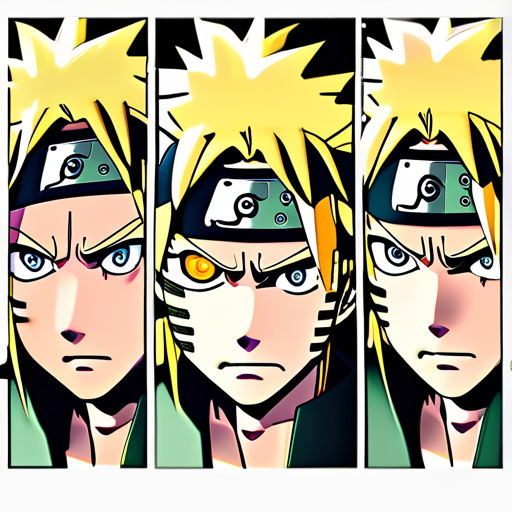

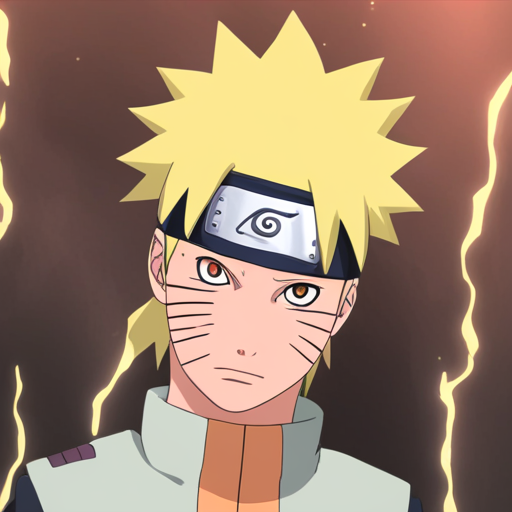

In [ ]:
import torch
from diffusers import StableDiffusionXLPipeline, DPMSolverMultistepScheduler
from peft import PeftModel       

BASE_MODEL  = "stabilityai/stable-diffusion-xl-base-1.0"
LORA_PATH   = "/content/drive/MyDrive/sdxl-naruto-lora"

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

prompt   = "Naruto Uzumaki in sage mode, golden glow around his eyes, dramatic lighting"
seed     = 1234
steps    = 30
guidance = 7.5
h, w     = 512, 512

# 1) Base pipeline
pipe_base = StableDiffusionXLPipeline.from_pretrained(
    BASE_MODEL,
    variant="fp16",
    torch_dtype=torch.float16,
    use_safetensors=True,
).to(device)

pipe_base.scheduler = DPMSolverMultistepScheduler.from_config(
    pipe_base.scheduler.config
)

g = torch.Generator(device=device).manual_seed(seed)
img_base = pipe_base(
    prompt=prompt,
    num_inference_steps=steps,
    guidance_scale=guidance,
    generator=g,
    height=h,
    width=w,
).images[0]

# 2) LoRA pipeline
pipe_lora = StableDiffusionXLPipeline.from_pretrained(
    BASE_MODEL,
    variant="fp16",
    torch_dtype=torch.float16,
    use_safetensors=True,
).to(device)

pipe_lora.scheduler = DPMSolverMultistepScheduler.from_config(
    pipe_lora.scheduler.config
)

print("Injecting PEFT LoRA into UNet...")
pipe_lora.unet = PeftModel.from_pretrained(
    pipe_lora.unet,   # base UNet from SDXL
    LORA_PATH,        # folder with adapter_model.safetensors + adapter_config.json
)
print("LoRA loaded.")

g = torch.Generator(device=device).manual_seed(seed)
img_lora = pipe_lora(
    prompt=prompt,
    num_inference_steps=steps,
    guidance_scale=guidance,
    generator=g,
    height=h,
    width=w,
    # cross_attention_kwargs={"scale": 1.0}, 
).images[0]

display(img_base)
display(img_lora)
